In [1]:
from collections import OrderedDict
from copy import copy
import single_sided_network
import qdyn_model
from notebook_plots import display_hamiltonian, show_summary
from sympy import Symbol
import QDYN
from QDYN.pulse import blackman, box
from QDYN.shutil import mkdir
from qnet.algebra.circuit_algebra import move_drive_to_H

In [2]:
%load_ext autoreload
%autoreload 2

## Circuit

### Single Node

In [3]:
circuit1 = single_sided_network.network_circuit(n_nodes=1, topology='driven_open')

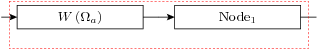

In [4]:
circuit1.show()

In [5]:
slh1 = single_sided_network.network_slh(n_cavity=2, n_nodes=1, topology='driven_open', inhom=True)

In [6]:
slh1.S

[[1]]

In [7]:
slh1.L

[[Ωₐ + √2⋅√κ * â^(c₁)]]

In [8]:
display_hamiltonian(slh1.H)

<IPython.core.display.Latex object>

### Two Nodes

In [9]:
circuit2 = single_sided_network.network_circuit(n_nodes=2, topology='driven_open')

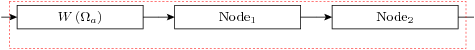

In [10]:
circuit2.show()

In [11]:
slh2 = single_sided_network.network_slh(n_cavity=5, n_nodes=2, topology='driven_open')

In [12]:
slh2.S

[[1]]

In [13]:
slh2.L

[[√2⋅√κ * â^(c₁) + √2⋅√κ * â^(c₂)]]

In [14]:
display_hamiltonian(slh2.H)

<IPython.core.display.Latex object>

## Numerical Values

In [15]:
#from algebra import generate_num_vals_code
#generate_num_vals_code(slh.all_symbols())

In [16]:
Delta =  5000.0  # MHz
g     =    50.0  # MHz
kappa =     0.5  # MHz
E0    =    70.0  # MHz
alpha =  100.0 # MHZ
t0    = -4    # microsec
T     =  4    # microsec
nt    = 2001
num_vals = {
    Symbol('Delta_1', real=True):   Delta,
    Symbol('Delta_2', real=True):   Delta,
    Symbol('g_2', positive=True):   g,
    Symbol('g_1', positive=True):   g,
    Symbol('kappa', positive=True): kappa,
    Symbol('alpha', real=True): alpha,
}

## Time Grid and Guess Pulse

In [17]:
tgrid = QDYN.pulse.pulse_tgrid(t0=t0, T=T, nt=nt) # microsec

In [18]:
p = QDYN.pulse.Pulse(
    tgrid, amplitude=(E0 * blackman(tgrid, t0, T)),
    time_unit='microsec', ampl_unit='MHz')

In [19]:
pzero = QDYN.pulse.Pulse(
    tgrid, amplitude=(0.0 * blackman(tgrid, t0, T)),
    time_unit='microsec', ampl_unit='MHz')

In [20]:
controls = OrderedDict([
    (Symbol('Omega_1'), pzero.copy()),
    #(Symbol('Omega_2'), pzero.copy()),
    (Symbol('Omega_a'), p.copy()),
])

## OCT for qubit excitation (single node)

### Analytical Pulse Sequence 

In [164]:
import matplotlib.pylab as plt

In [165]:
import numpy as np

In [166]:
%matplotlib inline

In [185]:
tgrid = QDYN.pulse.pulse_tgrid(t0=t0, T=T, nt=nt) # microsec

In [214]:
pa = QDYN.pulse.Pulse(
    tgrid, amplitude=(0.2*box(tgrid, -0.1, 0.0)),
    time_unit='microsec', ampl_unit='sqrt_MHz')

In [215]:
p1 = QDYN.pulse.Pulse(
    tgrid, amplitude=(500*box(tgrid, 0, 0.1)),
    time_unit='microsec', ampl_unit='MHz')

In [216]:
controls = OrderedDict([
    (Symbol('Omega_1'), p1),
    (Symbol('Omega_a'), pa),
])

### Propagation

In [217]:
model = qdyn_model.make_qdyn_oct_single_node_model(
    slh1, num_vals, controls, energy_unit='MHz',
    mcwf=False, non_herm=True, oct_target='excite_qubit',
    lambda_a=1e-4, nodiss=True)

In [218]:
model.write_to_runfolder("./NO_FB/qb_exc_single_diss_oct_hs001")

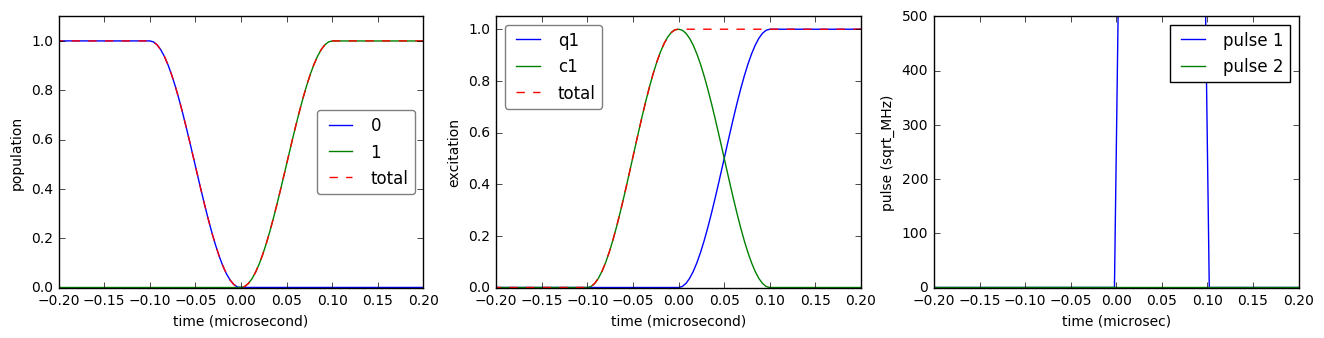

In [223]:
show_summary("./NO_FB/qb_exc_single_diss_oct_hs001", pulses='pulse*.dat', single_node=True, range=(-0.2, 0.2))

In [212]:
def plot_ex():
    dat = './NO_FB/qb_exc_single_diss_oct_hs001/excitation.dat'
    t, q, cav = np.genfromtxt(dat, unpack=True, usecols=(0,1,2))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(t, q)
    ax.set_xlim(0,4)
    plt.show(fig)

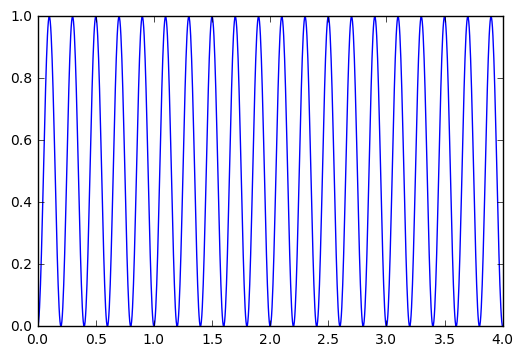

In [213]:
plot_ex()

## OCT for qubit excitation

In [ ]:
model = qdyn_model.make_qdyn_oct_model(
    slh, num_vals, controls, energy_unit='MHz',
    mcwf=True, non_herm=True, oct_target='excite_first_qubit',
    lambda_a=1e-4)

In [ ]:
model.write_to_runfolder("./NO_FB/qb_exc1_diss_oct_hs001")

## Example optimization commands

*   density matrix optimization (`mcwf=False, non_herm=False`)

        OMP_NUM_THREADS=1 qdyn_optimize --internal-units=GHz_units.txt --rho --debug --J_T=J_T_re .
        
*   trajectory optimization (`mcwf=True, non_herm=True|False`)

        OMP_NUM_THREADS=1 qdyn_optimize --internal-units=GHz_units.txt --n-trajs=20 --J_T=J_T_sm .

## Example propagation commands

* density matrix propagation

```
OMP_NUM_THREADS=1 qdyn_prop_traj --internal-units=GHz_units.txt --rho --use-oct-pulses --state-label=10 .
```

* trajectory propagation

```
OMP_NUM_THREADS=1 qdyn_prop_traj --internal-units=GHz_units.txt --n-trajs=10 --use-oct-pulses --state-label=10 .
```